In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel'
plt_dir = gwfm_dir+'/Levee_setback/figures/'
gwfm_dir


'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel'

## Pick model type to review
RIV is the simple model with only SS assumptions about Blodgett Dam depth and area
LAK is the complex model with interactive flow between the stream and Blodgett Dam

In [3]:
# model_type = 'RIV'
# model_type = 'LAK'

In [4]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/levee_setback/streamflow/'

runs = os.listdir(loadpth)
runs

['historical_SS',
 'historical_SS_realization033',
 'historical_SS_realization089',
 'historical_streamflow',
 'historical_streamflow000',
 'historical_streamflow033',
 'historical_streamflow089',
 'run_multiprocess.bat',
 'run_multiprocess.py',
 'setback_streamflow',
 'setback_streamflow000',
 'setback_streamflow033',
 'setback_streamflow089',
 'test.py',
 'test_mp.txt']

In [6]:
# model_ws =loadpth+'/actual_200cfs'

# i=0
# os.listdir(loadpth+runs[i])
# glob.glob(loadpth+runs[i]+'/*.nam')[0]
# model_ws = loadpth+runs[i]

model_ws = loadpth+'historical_streamflow'
# model_ws = loadpth+'setback_streamflow'

model_type = 'LAK'

In [7]:

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='MODFLOW-NWT.exe', version='mfnwt')
# m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
#                                 exe_name='mf2005.exe', version='mf2005')

In [12]:
# hk = m.lpf.hk.array
# hk_limit = np.quantile(hk,0.87)
# hk_high = np.zeros(hk.shape)
# hk_high[hk>hk_limit]=1
# hk_high[:,(m.lak.lakarr.array==1)[0,0,:,:]]+=2

In [13]:
# for n in [0,1,5,8,12]:
#     plt.imshow(hk_high[n])
#     plt.show()


In [14]:
sfr_dir = gwfm_dir+'/SFR_data/'
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

In [15]:
# m.dis.nper # perlen, nstp, tsmult, start_datetime
# num_days = np.cumsum(m.dis.perlen.array).astype('timedelta64[D]')
# spd_dates = pd.to_datetime(m.dis.start_datetime) + num_days - np.ones(1).astype('timedelta64[D]')

# m.dis.nstp.array
# m.dis.tsmult.array

In [16]:
# sfr_cols = ['name','row','column','segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
#             'stage', 'depth', 'width', 'Cond', 'gradient', 'kstpkper']


# sfrdf_all = pd.DataFrame(columns = sfr_cols)
# sfrdf_all.index.name = 'name'

# for i in np.arange(0,len(runs)):
#     sfrnam = loadpth+runs[i]+'/MF.sfr.out'
#     sfrout = flopy.utils.SfrFile(sfrnam)
#     sfrdf = sfrout.get_dataframe()
#     sfrdf['name'] = runs[i]
#     sfrdf_all = sfrdf_all.append(sfrdf.loc[:,sfr_cols])

In [17]:
pd_sfr = pd.DataFrame(grid_sfr.set_index(['row','column']).loc[:,['length_m','z']])
pd_sfr['Total distance (m)'] = pd_sfr['length_m'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(loadpth+ model_ws+'/MF.sfr.out')
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    
    sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin /(0.3048**3)/86400
    sfrdf_plot['Qaquifer_AF'] = sfrdf_plot.Qaquifer /(0.3048**3)/43560
    sfrdf_plot = sfrdf_plot.set_index('dt')
    return(sfrdf_plot)



In [18]:
# gage file output
#Option 0: Use standard default listing of time, stage, volume, and concentration.
#Option 1: Default values plus all inflows to and outflows from lake (as volumes during time increment),
#total lake conductance, and time-step budget error (percent).
#Computed runoff from UZF and lake infiltration to UZF is added whenever the UZF Package is active 
# gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

In [19]:
def read_gage(run):
    gagenam = loadpth+run+'/MF.gage1.go'
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    gage['name'] = run
    # convert from m3/day to cfs
    gage['Inflw_cfs'] = gage['SW-Inflw'] /(0.3048**3)/86400
    gage['Outflw_cfs'] = gage['SW-Outflw'] /(0.3048**3)/86400
    gage['Seepage_cfs']  = gage['GW-Outflw'] /(0.3048**3)/86400
    gage['Time'] = strt_date + gage.Time.values.astype('timedelta64[D]')
    gage = gage.set_index('Time')
    return(gage)

# historical_gage = read_gage('historical_streamflow')

# for i in np.arange(1,len(runs[0:8])):
#     go = read_gage(runs[i])
#     gage = gage.append(go)


<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
C:\Users\ajcalder\AppData\Local\Temp/ipykernel_157280/3161864768.py:3: DeprecationWarning: invalid escape sequence \s
  gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')


In [20]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
# cbc = model_ws+'/MF.cbc'
strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp

In [21]:
setback_df = clean_sfr_df('setback_streamflow')
historical_df = clean_sfr_df('historical_streamflow')

setback_gage = read_gage('setback_streamflow')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\fsspec\__init__.py:47: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for spec in entry_points.get("fsspec.specs", []):


In [22]:
historical_join = historical_df.loc[:,['Qin_cfs','Qaquifer_AF', 'depth','kstpkper','i','j']].\
    set_index(['kstpkper','i','j'])
sfrdf_plot = setback_df.join(historical_join, on=['kstpkper','i','j'], rsuffix = '_historic',lsuffix='_setback')

In [23]:
sfrdf_plot['Qin_cfs_diff'] = sfrdf_plot.Qin_cfs_setback - sfrdf_plot.Qin_cfs_historic
sfrdf_plot['Qaquifer_AF_diff'] = sfrdf_plot.Qaquifer_AF_setback - sfrdf_plot.Qaquifer_AF_historic
sfrdf_plot['depth_diff'] = sfrdf_plot.depth_setback - sfrdf_plot.depth_historic

Text(0, 0.5, 'Seepage to Aquifer')

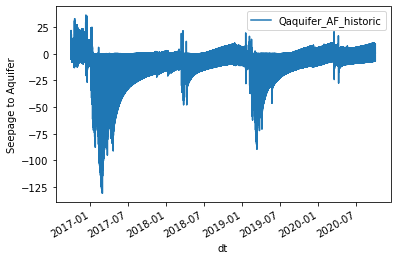

In [28]:
sfrdf_plot.plot(y='Qaquifer_AF_historic')
plt.ylabel('Seepage to Aquifer')

# Graphics for ISMAR 2022

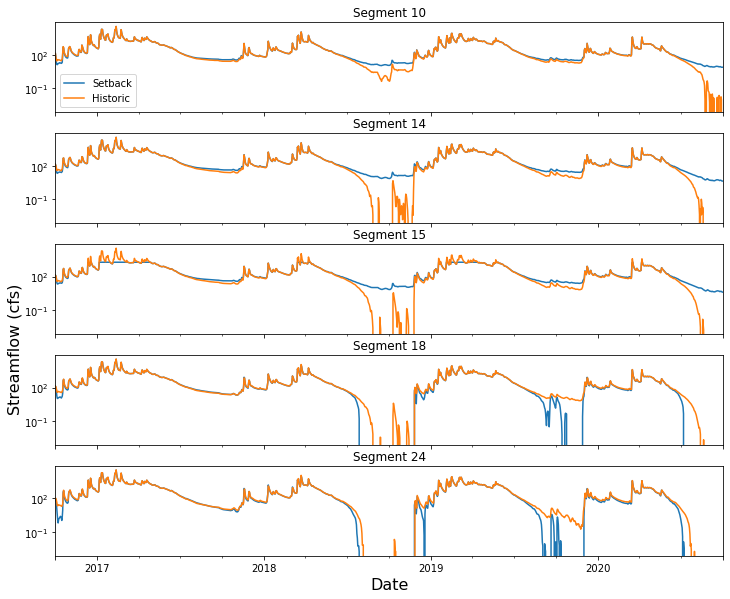

In [292]:
# start flow, before diversion, after diversion, after floodplain, midway to end, end
segments2check = np.asarray([10,14, 15, 18,24])
fig,ax=plt.subplots(len(segments2check),1,figsize=(10,8),sharex='col', sharey='col')
fig.tight_layout()

for i,nseg in enumerate(segments2check):
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_setback',ax=ax[i],
                                                                         label='Setback',linestyle='-',legend=False)
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_historic',ax=ax[i],
                                                                     label='Historic',linestyle='-',legend=False)
    ax[i].set_title('Segment '+str(nseg))
# sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_diff',ax=ax[0],
#                                                                      label=str(nseg),linestyle='--')
ax[0].legend()
ax[0].set_yscale("log", base=10)

# ax[0].set_xlim('2019-01-01','2019-07-01')
fig.text(-0.02,0.3,'Streamflow (cfs)',rotation='vertical',size=16)
plt.xlabel('Date',size=16)

plt.savefig(plt_dir+'selected_streamflow_logscale.png',dpi=600,bbox_inches='tight')

Text(0.5, 50.99999999999994, 'Date')

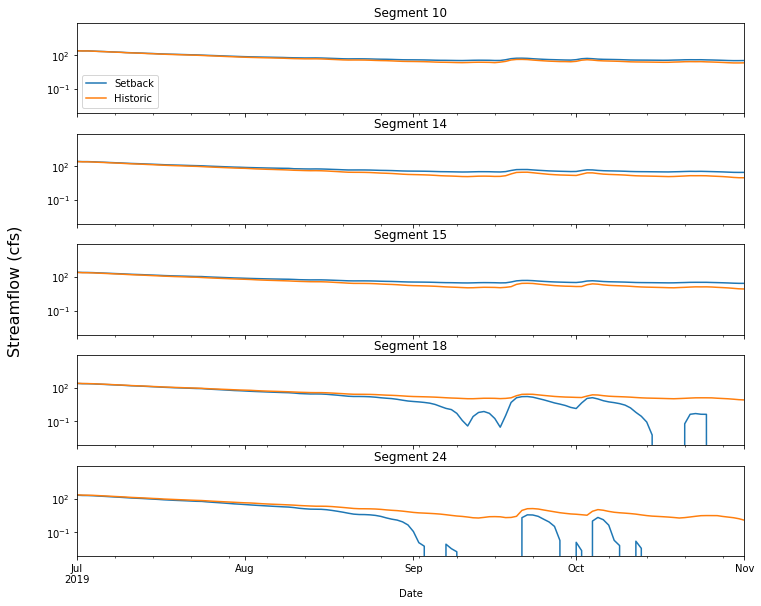

In [291]:
# start flow, before diversion, after diversion, after floodplain, midway to end, end
segments2check = np.asarray([10, 14, 15, 18,24])
fig,ax=plt.subplots(len(segments2check),1,figsize=(10,8),sharex='col',sharey='col')
fig.tight_layout()

for i,nseg in enumerate(segments2check):
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_setback',ax=ax[i],
                                                                         label='Setback',linestyle='-',legend=False)
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_historic',ax=ax[i],
                                                                     label='Historic',linestyle='-',legend=False)
    ax[i].set_title('Segment '+str(nseg))
# sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_diff',ax=ax[0],
#                                                                      label=str(nseg),linestyle='--')
ax[0].legend()
ax[0].set_xlim('2019-07-01','2019-11-01')
# ax[0].set_ylim(0,200)
ax[0].set_yscale("log", base=10)
fig.text(-0.05,0.4, 'Streamflow (cfs)', rotation='vertical',size=16)
plt.xlabel('Date')

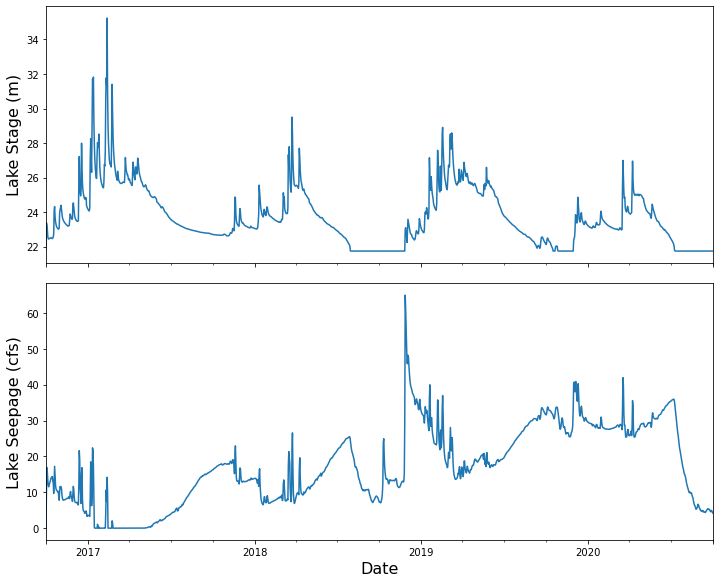

In [266]:
fig,ax=plt.subplots(2,1,figsize=(10,8),sharex='col')
fig.tight_layout()

setback_gage.plot(y='Stage(H)',ax=ax[0],legend=False)
ax[0].set_ylabel('Lake Stage (m)',size=16)
# setback_gage.plot(y='Inflw_cfs',ax=ax[-2],label = 'Inflow')
# ax[-2].set_ylabel('Lake Flow (cfs)')

# setback_gage.plot(y='Outflw_cfs',ax=ax[-2],label = 'Outflow',linestyle='--')
setback_gage.plot(y='Seepage_cfs',ax=ax[1],legend=False)
ax[1].set_ylabel('Lake Seepage (cfs)',size=16)
plt.xlabel('Date',size=16)

plt.savefig(plt_dir+'lake_stage_seepage.png',dpi=600,bbox_inches='tight')



In [275]:
(setback_gage.Seepage_cfs*86400/43560).resample('AS-Oct').sum() # convert to cubic feet per day then into AF/day


Time
2016-10-01     4202.401490
2017-10-01    10166.315339
2018-10-01    16832.552496
2019-10-01    18798.361566
2020-10-01       16.416435
Freq: AS-OCT, Name: Seepage_cfs, dtype: float64

In [202]:
event_dates = ['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01']
post_dates = ['2019-7-01','2019-8-01','2019-9-01','2019-10-01','2019-11-01']
# mon_dates = pd.date_range('2018-10-01','2019-09-30', freq='MS')

mon_dates = pd.date_range('2016-10-01','2020-09-30', freq='MS')

mon_dates

DatetimeIndex(['2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', freq='MS')

<AxesSubplot:xlabel='Total distance (m)'>

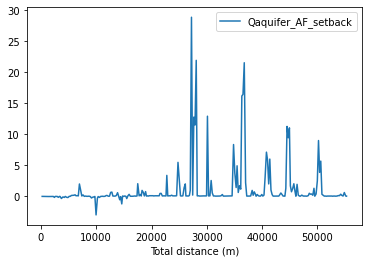

In [297]:
sfr_mon = sfrdf_plot.groupby(['segment','reach']).resample('MS').mean().drop(['segment','reach'],axis=1).reset_index()
sfr_mon = sfr_mon.set_index('dt')

sfr_mon.loc[sfr_mon.index=='2019-01-01'].plot(x='Total distance (m)',y='Qaquifer_AF_setback')

In [326]:
# setback - historic
sfrdf_plot.resample('AS-Oct').sum().loc[:,['Qaquifer_AF_setback','Qaquifer_AF_historic','Qaquifer_AF_diff']]

,Qaquifer_AF_setback,Qaquifer_AF_historic,Qaquifer_AF_diff
dt,,,
2016-10-01,-43995.959828,-64675.862007,20679.902179
2017-10-01,30469.617875,42673.410090,-12203.792215
2018-10-01,65228.479855,86658.309290,-21429.829435
2019-10-01,54879.846039,80823.763379,-25943.917340
2020-10-01,14.795724,21.595878,-6.800154


In [327]:
sfrdf_plot.resample('AS-Oct').mean().loc[:,['Qin_cfs_setback','Qin_cfs_historic','Qin_cfs_diff']]

,Qin_cfs_setback,Qin_cfs_historic,Qin_cfs_diff
dt,,,
2016-10-01,1679.547650,1706.872133,-27.324483
2017-10-01,391.610026,393.478171,-1.868145
2018-10-01,910.405571,919.191817,-8.786245
2019-10-01,189.640501,189.849930,-0.209429
2020-10-01,2.735940,1.065692,1.670248


Text(0.3, 0.04, 'Distance downstream (m)')

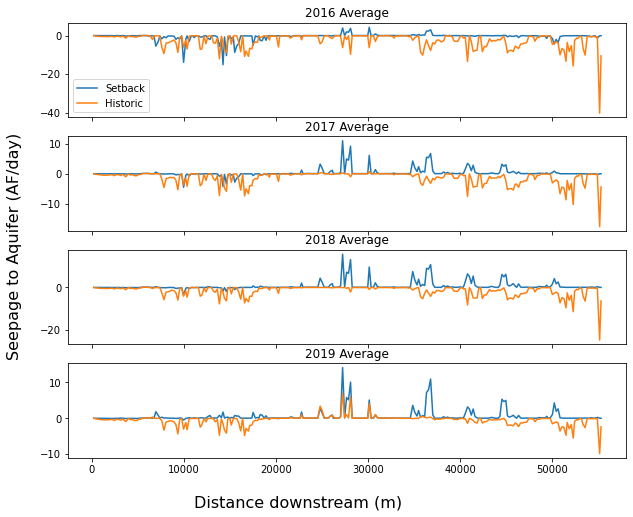

In [29]:
sfr_ann = sfrdf_plot.groupby(['segment','reach']).resample('AS-Oct').mean().drop(['segment','reach'],axis=1).reset_index()
sfr_ann = sfr_ann.set_index('dt')

fig,ax=plt.subplots(4,1,figsize=(10,8),sharex='col')
for n,y in enumerate(pd.date_range('2016-10-01','2020-09-30',freq='AS-Oct')):
    ax[n].set_title(str(y.year)+ ' Average')
    sfr_ann.loc[y].plot(x='Total distance (m)',y='Qaquifer_AF_setback',ax=ax[n],legend=False,label='Setback')
    sfr_ann.loc[y].plot(x='Total distance (m)',y='Qaquifer_AF_historic',ax=ax[n],legend=False,label='Historic')

# sfr_ann
ax[-1].set_xlabel('')
ax[0].legend()
fig.text(0.04,0.3,'Seepage to Aquifer (AF/day)', rotation='vertical',size=16)
fig.text(0.3,0.04,'Distance downstream (m)', size=16)
# plt.savefig(plt_dir+'annual_avg_strm_seepage_AF.png',dpi=600,bbox_inches='tight')

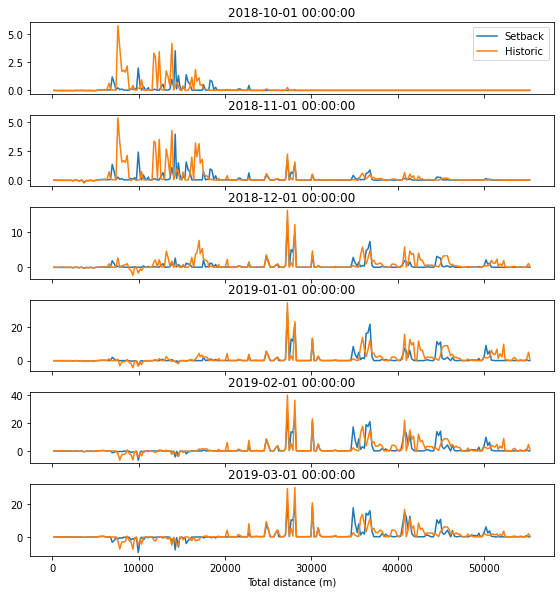

In [299]:
fig,ax=plt.subplots(int(len(mon_dates)/2),1,figsize=(8,8),sharex='col')
fig.tight_layout()
for n, plt_date in enumerate(mon_dates[0:6]):
    ax_n = ax[n]
#     sfrdf_plot.loc[sfrdf_plot.index==plt_date].plot(x='Total distance (m)',y='Qin_cfs_diff',ax=ax[-3],legend=False)
#     sfr_mon.loc[sfr_mon.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_diff',ax=ax_n)
    sfr_mon.loc[sfr_mon.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_setback',
                                              ax=ax_n,legend=False,label='Setback')
    sfr_mon.loc[sfr_mon.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_historic',
                                              ax=ax_n,legend=False,label='Historic')


    ax_n.set_title(plt_date)
ax[0].legend()

Text(0, 0.2, 'Difference in Aquifer Seepage (AF/day) \nbetween Setback and Historic')

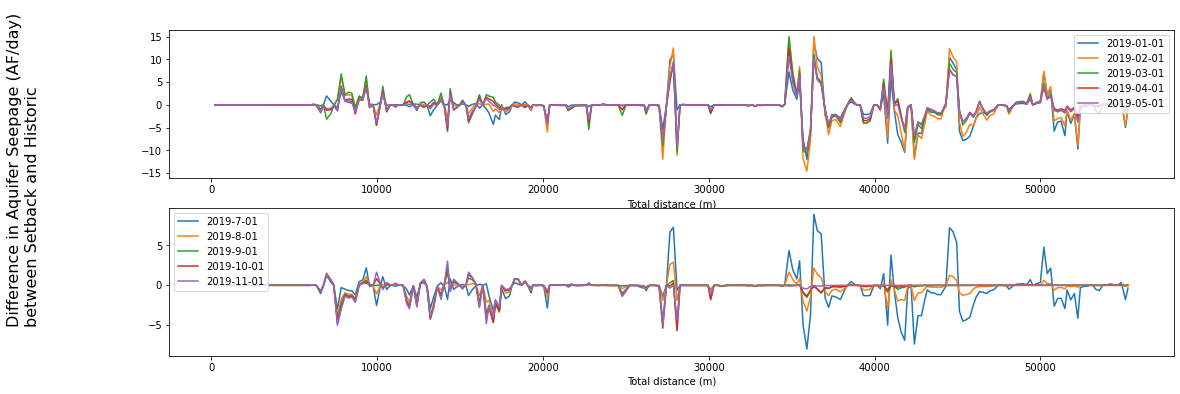

In [319]:
fig,ax=plt.subplots(2,1,figsize=(18,6))
# fig.tight_layout()
for plt_date in event_dates:
#     sfrdf_plot.loc[sfrdf_plot.index==plt_date].plot(x='Total distance (m)',y='Qin_cfs_diff',ax=ax[-3],legend=False)
    sfr_mon.loc[sfr_mon.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_diff',ax=ax[0],label=plt_date)
#     sfr_mon.loc[sfr_mon.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_diff',ax=ax[-1,0],label=plt_date)
for plt_date in post_dates:  
    sfr_mon.loc[sfr_mon.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_diff',ax=ax[1],label=plt_date)
    
fig.text(0,0.2, 'Difference in Aquifer Seepage (AF/day) \nbetween Setback and Historic',size=16,rotation='vertical')
# for plt_date in event_dates:
# #     sfrdf_plot.loc[sfrdf_plot.index==plt_date].plot(x='Total distance (m)',y='Qin_cfs_diff',ax=ax[-3],legend=False)
#     sfrdf_plot.loc[sfrdf_plot.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_diff',ax=ax[-2,0],label=plt_date)
# for plt_date in post_dates:  
#     sfrdf_plot.loc[sfrdf_plot.index==plt_date].plot(x='Total distance (m)',y='Qaquifer_AF_diff',ax=ax[-2,1],label=plt_date)

In [37]:
# temp = sfrdf_plot.loc[sfrdf_plot.name=='actual_0025cfs']
# temp = temp.loc[(temp.segment>13)&(temp.segment<21)]
# # temp.plot(x='Total distance (m)',y='Qin')
# temp.plot(x='segment',y='Qin')

In [65]:
# fig,ax=plt.subplots(2,1,figsize=(8,6),sharex=True)
# for i in sfrdf_plot.name.unique():
#     typ='-'
#     if 'new' in i:
#         typ='--'
# #     elif 'actual' in i:
# #         typ = '-*'
#     sfrdf_plot.loc[sfrdf_plot.name==i].plot(ax=ax[0],x='Total distance (m)',y='Qin_cfs',label=i,legend=False, style=typ)
#     sfrdf_plot.loc[sfrdf_plot.name==i].plot(ax=ax[1],x='Total distance (m)',y='Qaquifer_AF',label=i,legend=False, style=typ)

# # plt.legend(orientation='horizontal')
# ax[0].legend(loc=[0.1,1.05],ncol=3)
# ax[0].set_ylabel('Discharge (cfs)')
# ax[1].set_ylabel('Streambed seepage (AF/day)') #($m^3$/d)

# plt.savefig(plt_dir+'/streamflow between scenarios '+model_type+'.png',dpi=600,bbox_inches='tight')

In [64]:

# for flow in ['0025','0100']:
#     fig,axes = plt.subplots(2,1,figsize=(8,8),sharex=True)

#     ax=axes[0]
#     flownam = '_'+flow+'cfs'
#     if75 = (sfrdf_plot.name=='actual'+flownam) |(sfrdf_plot.name=='design'+flownam)|(sfrdf_plot.name=='new'+flownam)
#     sfrdf_75 = sfrdf_plot.loc[if75]
#     sfrdf_75_dam = sfrdf_75.loc[(sfrdf_75['Total distance (m)']>18600 ) &(sfrdf_75['Total distance (m)']<21000)]

#     # sfrdf_75_dam.Qaquifer = sfrdf_75_dam.groupby('name').cumsum().Qaquifer
#     sfrdf_75_dam.groupby('name').plot(x = 'Total distance (m)',y='Qaquifer',ax=ax)

#     ax.legend(['Actual','Design','New'])
#     ax.set_ylabel('$\mathregular{Q_{aquifer}}$ ($m^3$/day)')

#     ax.annotate("Blodgett Dam", xy=(0.35, 0.3), xytext=(0.2,0.5), xycoords="axes fraction",
#                arrowprops=dict(arrowstyle="->",
#                                 connectionstyle="arc3"))

#     ax=axes[1]
#     # filter out just 75 cfs scenario for comparison
#     if75 = (sfrdf_plot.name=='actual'+flownam) |(sfrdf_plot.name=='design'+flownam)|(sfrdf_plot.name=='new'+flownam)
#     sfrdf_75 = sfrdf_plot.loc[if75]
#     sfrdf_75_dam = sfrdf_75.loc[(sfrdf_75['Total distance (m)']>18600 ) &(sfrdf_75['Total distance (m)']<21000)]

#     # fig,ax = plt.subplots(figsize=(6,6))
#     sfrdf_75_dam.Qaquifer = sfrdf_75_dam.groupby('name').cumsum().Qaquifer
#     sfrdf_75_dam.groupby('name').plot(x = 'Total distance (m)',y='Qaquifer',ax=ax)

#     ax.legend(['Actual','Design','New'])
#     ax.set_ylabel('Cumulative Seepage ($m^3$/day)')
#     ax.set_xlabel('Total Distance (m) \n from Michigan Bar')

#     ax.annotate("Blodgett Dam", xy=(0.37, 0.3), xytext=(0.42,0.1), xycoords="axes fraction",
#                arrowprops=dict(arrowstyle="->",
#                                 connectionstyle="arc3"))
#     plt.savefig(plt_dir+'sfr stream seepage all'+flownam+'.png',dpi=600,bbox_inches='tight')

In [34]:
def calc_lak_out(C, n, slope, lak_stage, str_top, width):
    # is either 1.486 for cfs or 1 for cms or 86400 for cmd
    flow = (C/n)*width*(((lak_stage-str_top)*(2/3))**(5/3))*((slope)**(1/2))
    return(flow)
dam_str_top = 22.111436
# dam_str_top = 21.92
dam_slope = 0.0003
# dam_slope = 0.0008
dam = calc_lak_out(86400,0.048,dam_slope,22.594511, dam_str_top,20)

s1 = (124.5-116.5)/(1000*6+500+750)
s2 = (114.85-110.65)/(1000*4+559*2)
s1,s2
ex1 = calc_lak_out(C=1.486*86400,n = 0.05,slope = s2,lak_stage=118.10,str_top = 114.85,width=5)
dam, ex1

(94348.56532363672, 1334321.7323914967)